In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from rdkit import Chem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 300

# Load Data

In [5]:
data = pd.read_csv('../data/tox24_train.csv')
data.head()

,SMILES,activity
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
activity,1012.0,40.813043,36.512641,-45.0,11.05,30.0,73.3,111.1


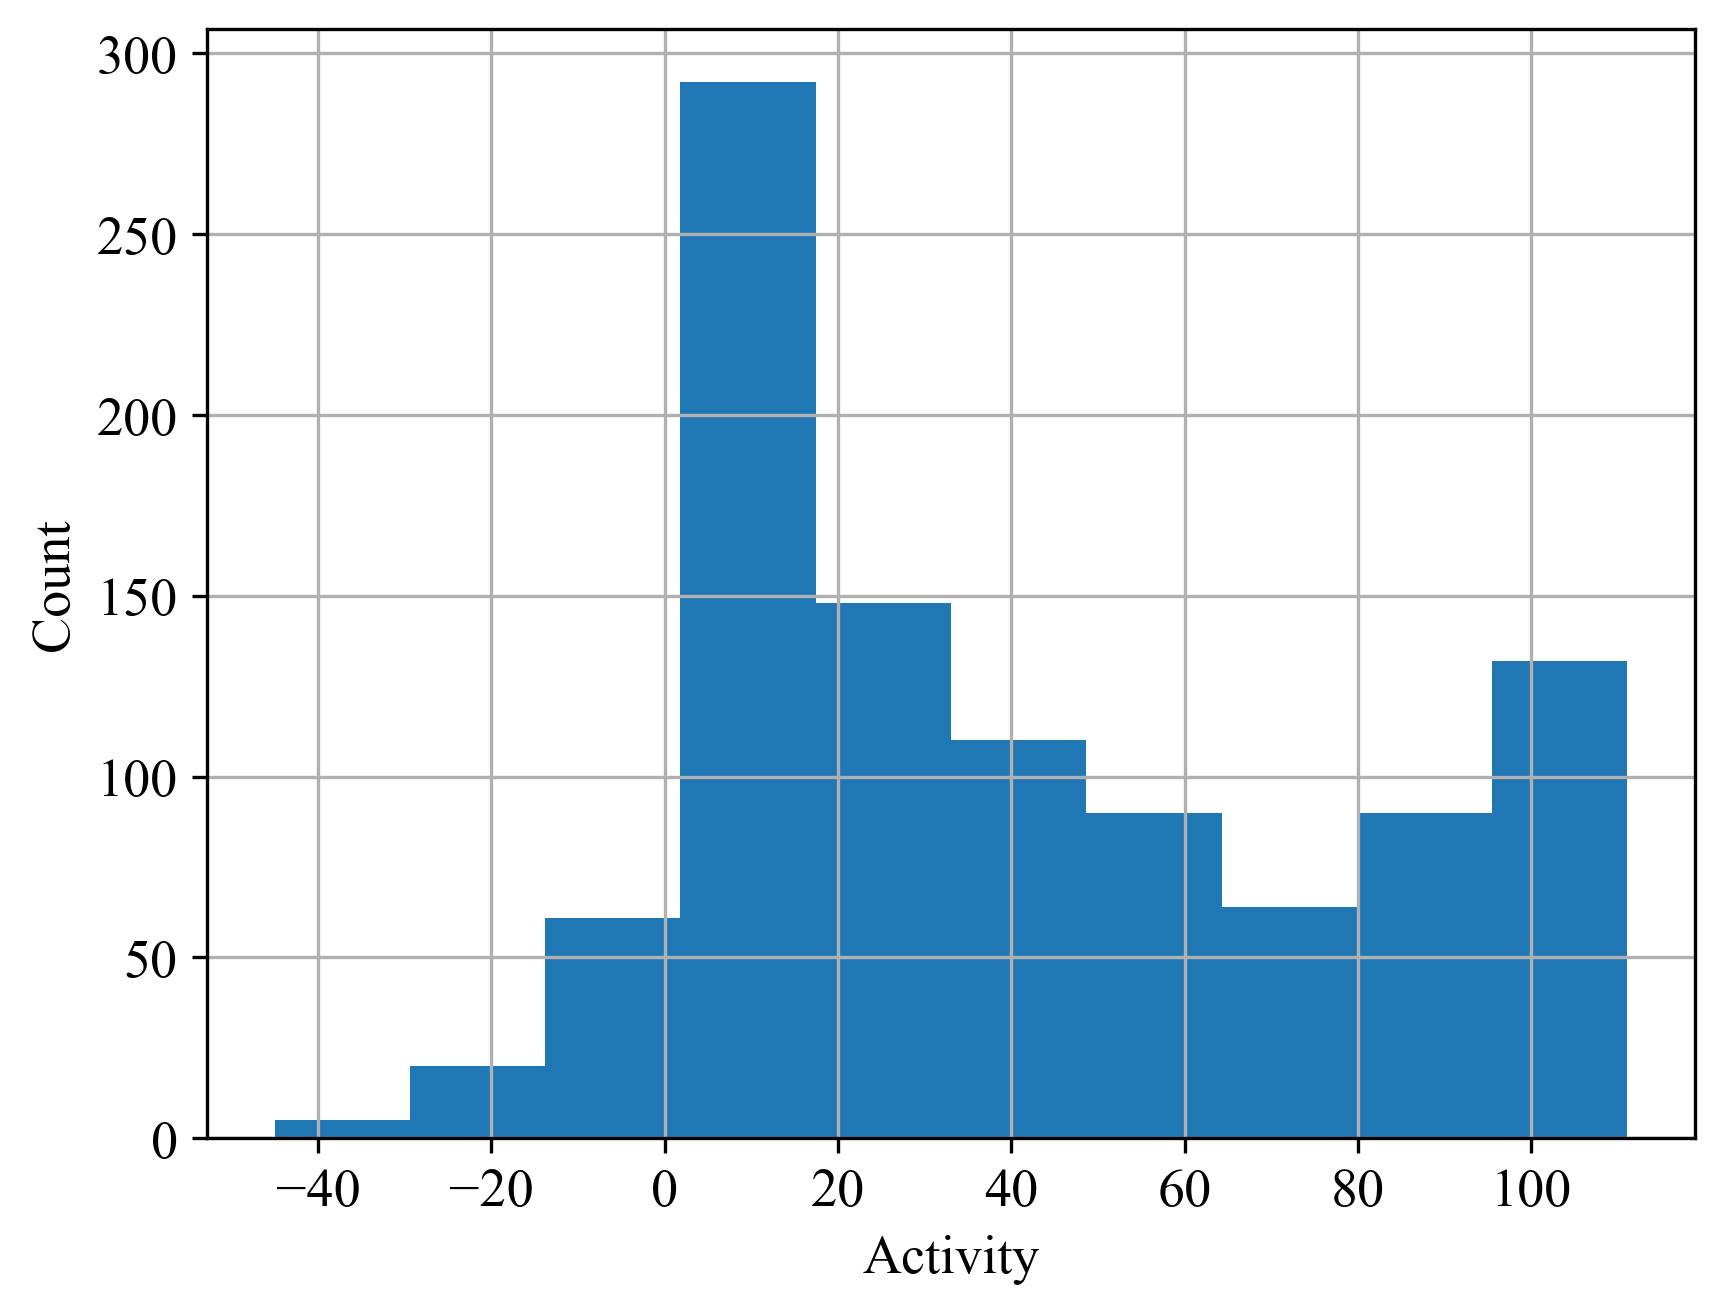

In [7]:
data['activity'].hist()
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

In [8]:
# conver smiles to canonical smiles
def canonicalizer(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

In [9]:
data['activity'] = data['activity'].apply(float)
data['can_SMILES'] = data['SMILES'].apply(canonicalizer)

In [10]:
data.head()

,SMILES,activity,can_SMILES
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3,C=C1CC[C@H]2C[C@@H]1C2(C)C
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1,COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1,CCCCCCCCCCCCCC(=O)OCC(O)CO
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4,CCCCCCCCCC=CCC1CC(=O)OC1=O


In [11]:
# compare two smiles by showing their structures
def compare_smiles(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    img1 = Chem.Draw.MolToImage(mol1)
    img2 = Chem.Draw.MolToImage(mol2)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[1].imshow(img2)
    ax[1].axis('off')
    plt.show()

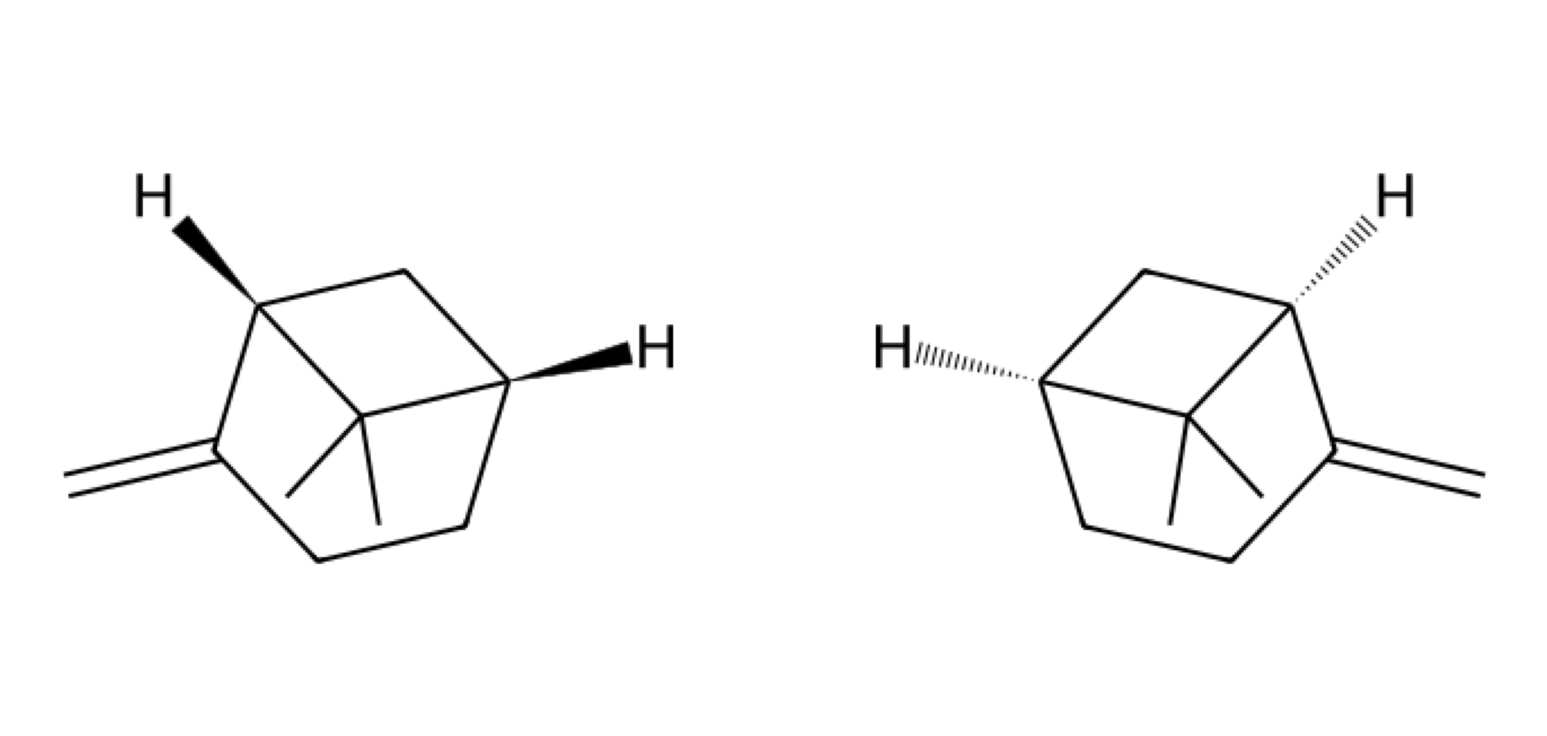

In [12]:
compare_smiles(data['SMILES'][0], data['can_SMILES'][0])

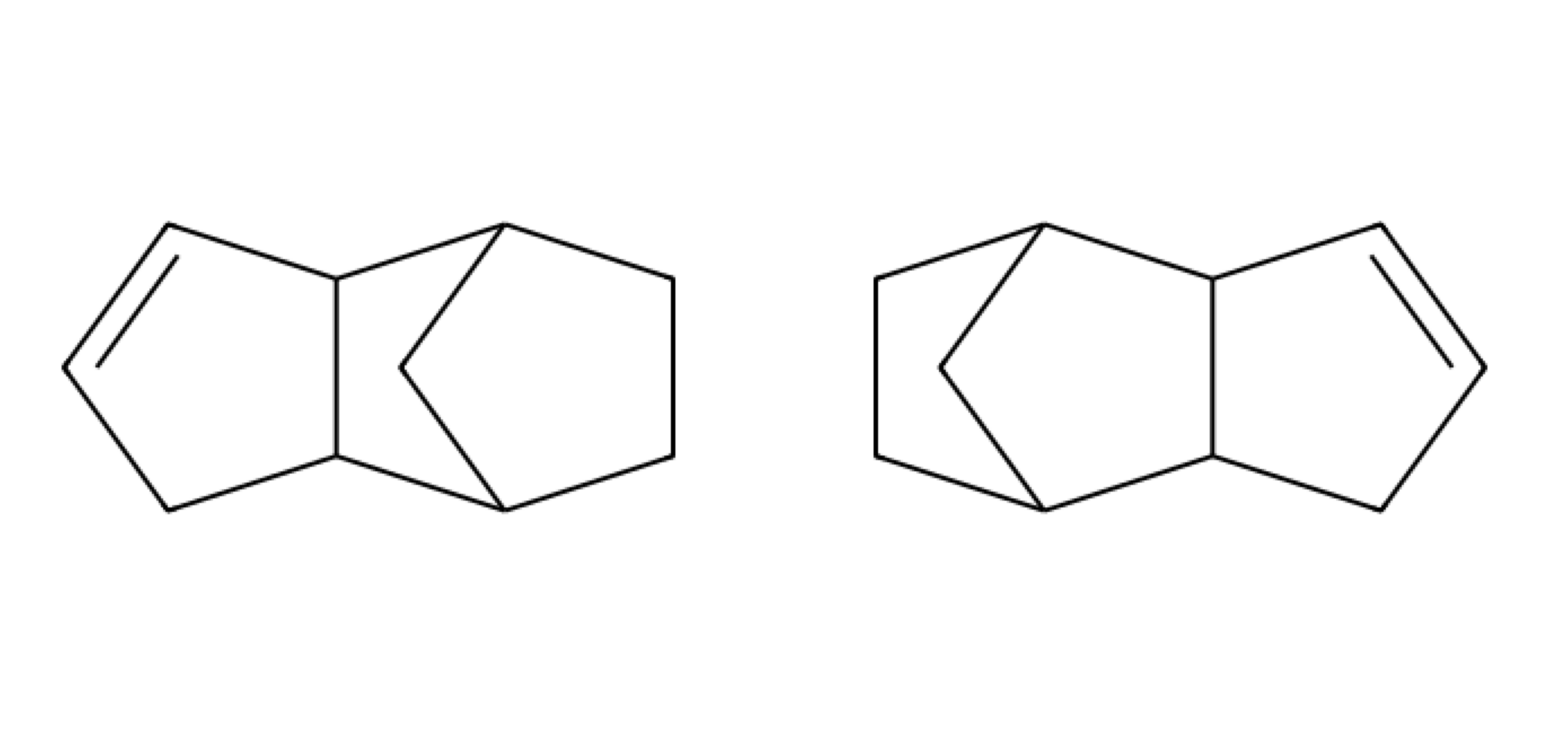

In [13]:
compare_smiles(data['SMILES'][10], data['can_SMILES'][10])

# Compute Descriptors

In [14]:
from rdkit.Chem import Descriptors

def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [15]:
# add each entry in descriptors to the dataframe
data['mol'] = data['can_SMILES'].apply(Chem.MolFromSmiles)
# add the descriptors to the dataframe
data = pd.concat([data, data['mol'].apply(getMolDescriptors).apply(pd.Series)], axis=1)

In [16]:
data.head()

,SMILES,activity,can_SMILES,mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3,C=C1CC[C@H]2C[C@@H]1C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x297381660>,4.128727,4.128727,0.606481,0.606481,0.448983,42.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1,COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x2973814a0>,11.291874,11.291874,0.423278,-0.678261,0.738016,11.636364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1,CCCCCCCCCCCCCC(=O)OCC(O)CO,<rdkit.Chem.rdchem.Mol object at 0x2973813c0>,11.308802,11.308802,0.103805,-0.952522,0.358261,12.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x2975616d0>,11.007067,11.007067,0.125394,-0.125394,0.602705,44.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4,CCCCCCCCCC=CCC1CC(=O)OC1=O,<rdkit.Chem.rdchem.Mol object at 0x2975617b0>,11.199135,11.199135,0.238154,-0.379186,0.257917,19.315789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0


In [17]:
# set seed
seed = 104
# set the test size
test_size = 0.2
# split the data
train_data, test_data = train_test_split(data, test_size=test_size, random_state=seed)
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (809, 214)
Test data shape: (203, 214)


In [18]:
train_data.head()

,SMILES,activity,can_SMILES,mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
796,[O-][N+](=O)C1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1Cl,69.7,O=[N+]([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,<rdkit.Chem.rdchem.Mol object at 0x297596820>,10.534636,10.534636,0.102840,-0.779012,0.321157,10.357143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,ON=C1CCCCC1,11.1,ON=C1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x295083740>,8.278981,8.278981,0.982639,0.982639,0.376663,20.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,CCCCC(CC)CO,8.6,CCCCC(CC)CO,<rdkit.Chem.rdchem.Mol object at 0x29451d660>,8.752651,8.752651,0.371528,0.371528,0.604543,13.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341,CC(C)(C1=CC=C(OCC2CO2)C=C1)C1=CC=C(OCC2CO2)C=C1,31.9,CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1,<rdkit.Chem.rdchem.Mol object at 0x295064dd0>,5.718539,5.718539,0.087037,-0.087037,0.689246,21.680000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,O=C(OCC1=CC=CC=C1)C=CC1=CC=CC=C1,75.4,O=C(C=Cc1ccccc1)OCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x295064970>,11.480663,11.480663,0.304368,-0.330828,0.602125,10.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train Model

In [19]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import pickle

In [20]:
X_train = train_data.drop(columns=['SMILES', 'can_SMILES', 'activity', 'mol'])
y_train = train_data['activity']

X_test = test_data.drop(columns=['SMILES', 'can_SMILES', 'activity', 'mol'])
y_test = test_data['activity']

In [21]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [22]:
def percentage_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

# Hyperparameter tuning

In [23]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.metrics import mean_squared_error

In [24]:
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 1000, 20)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 20)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'seed': hp.choice('seed', [0, 42, 104, 500])
}

def objective(params):
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train_scaled, y_train)
    y_pred = xgb_model.predict(X_test_scaled)
    score = mean_squared_error(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK} 

In [25]:
# Perform the optimization
best_params = fmin(objective, search_space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [05:42<00:00,  3.43s/trial, best loss: 654.62052593592] 
Best set of hyperparameters:  {'learning_rate': 0.09916398899082297, 'max_depth': 0.0, 'min_child_weight': 7.0519926461727875, 'n_estimators': 660.0, 'reg_alpha': 0.010877527599987278, 'reg_lambda': 0.013248287996946752, 'seed': 1}


# Retraining of model

Fold 1
Train RMSE: 0.112 %; Val RMSE: 8.997 %; Test RMSE: 8.415 %
Train R2: 0.994; Val R2: 0.361; Test R2: 0.492
Fold 2
Train RMSE: 0.184 %; Val RMSE: 2.447 %; Test RMSE: 8.344 %
Train R2: 0.987; Val R2: 0.546; Test R2: 0.424
Fold 3
Train RMSE: 0.078 %; Val RMSE: 3.139 %; Test RMSE: 8.040 %
Train R2: 0.998; Val R2: 0.445; Test R2: 0.511
Fold 4
Train RMSE: 0.186 %; Val RMSE: 4.146 %; Test RMSE: 7.488 %
Train R2: 0.988; Val R2: 0.443; Test R2: 0.483
Fold 5
Train RMSE: 0.192 %; Val RMSE: 9.751 %; Test RMSE: 7.596 %
Train R2: 0.990; Val R2: 0.548; Test R2: 0.493


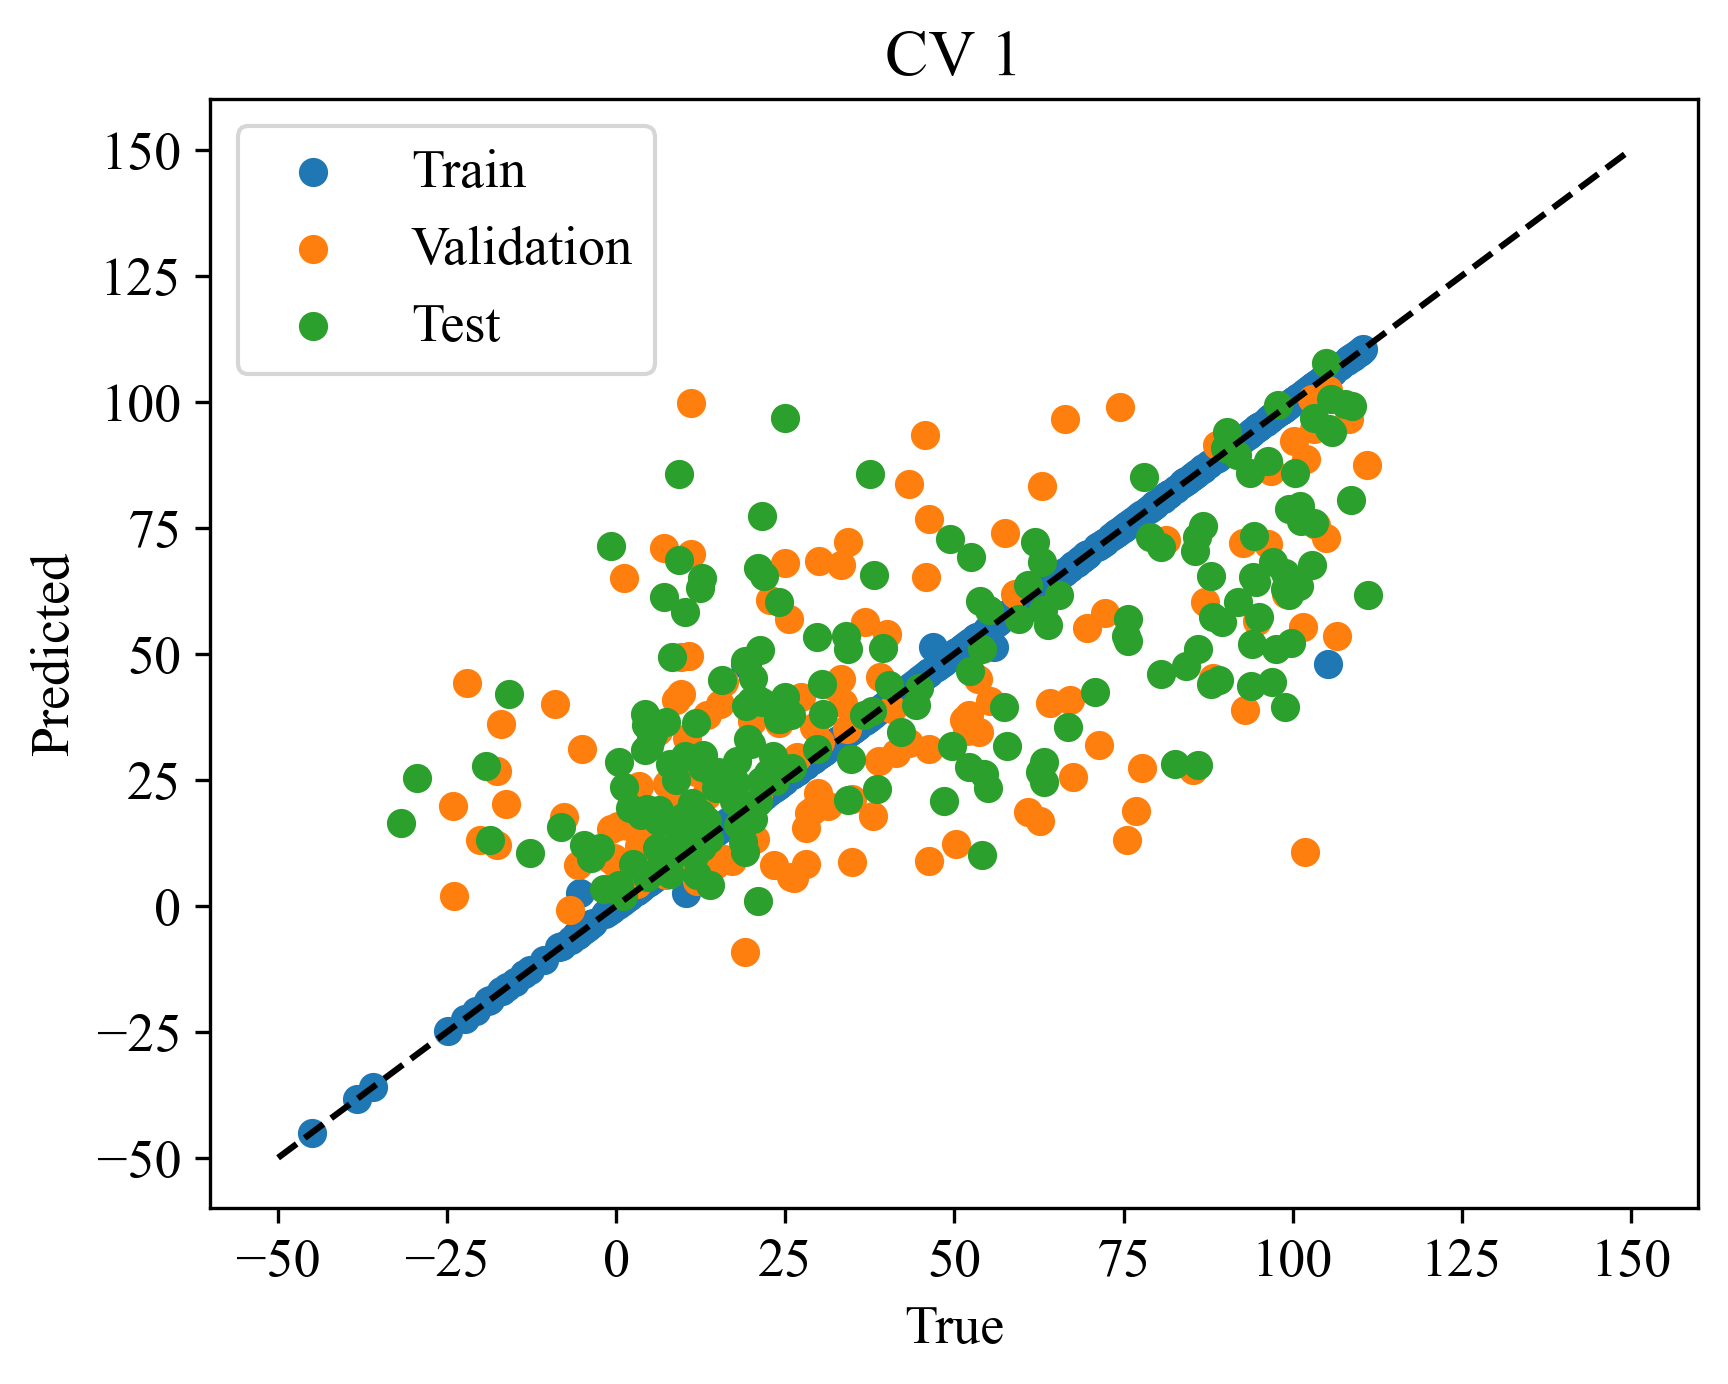

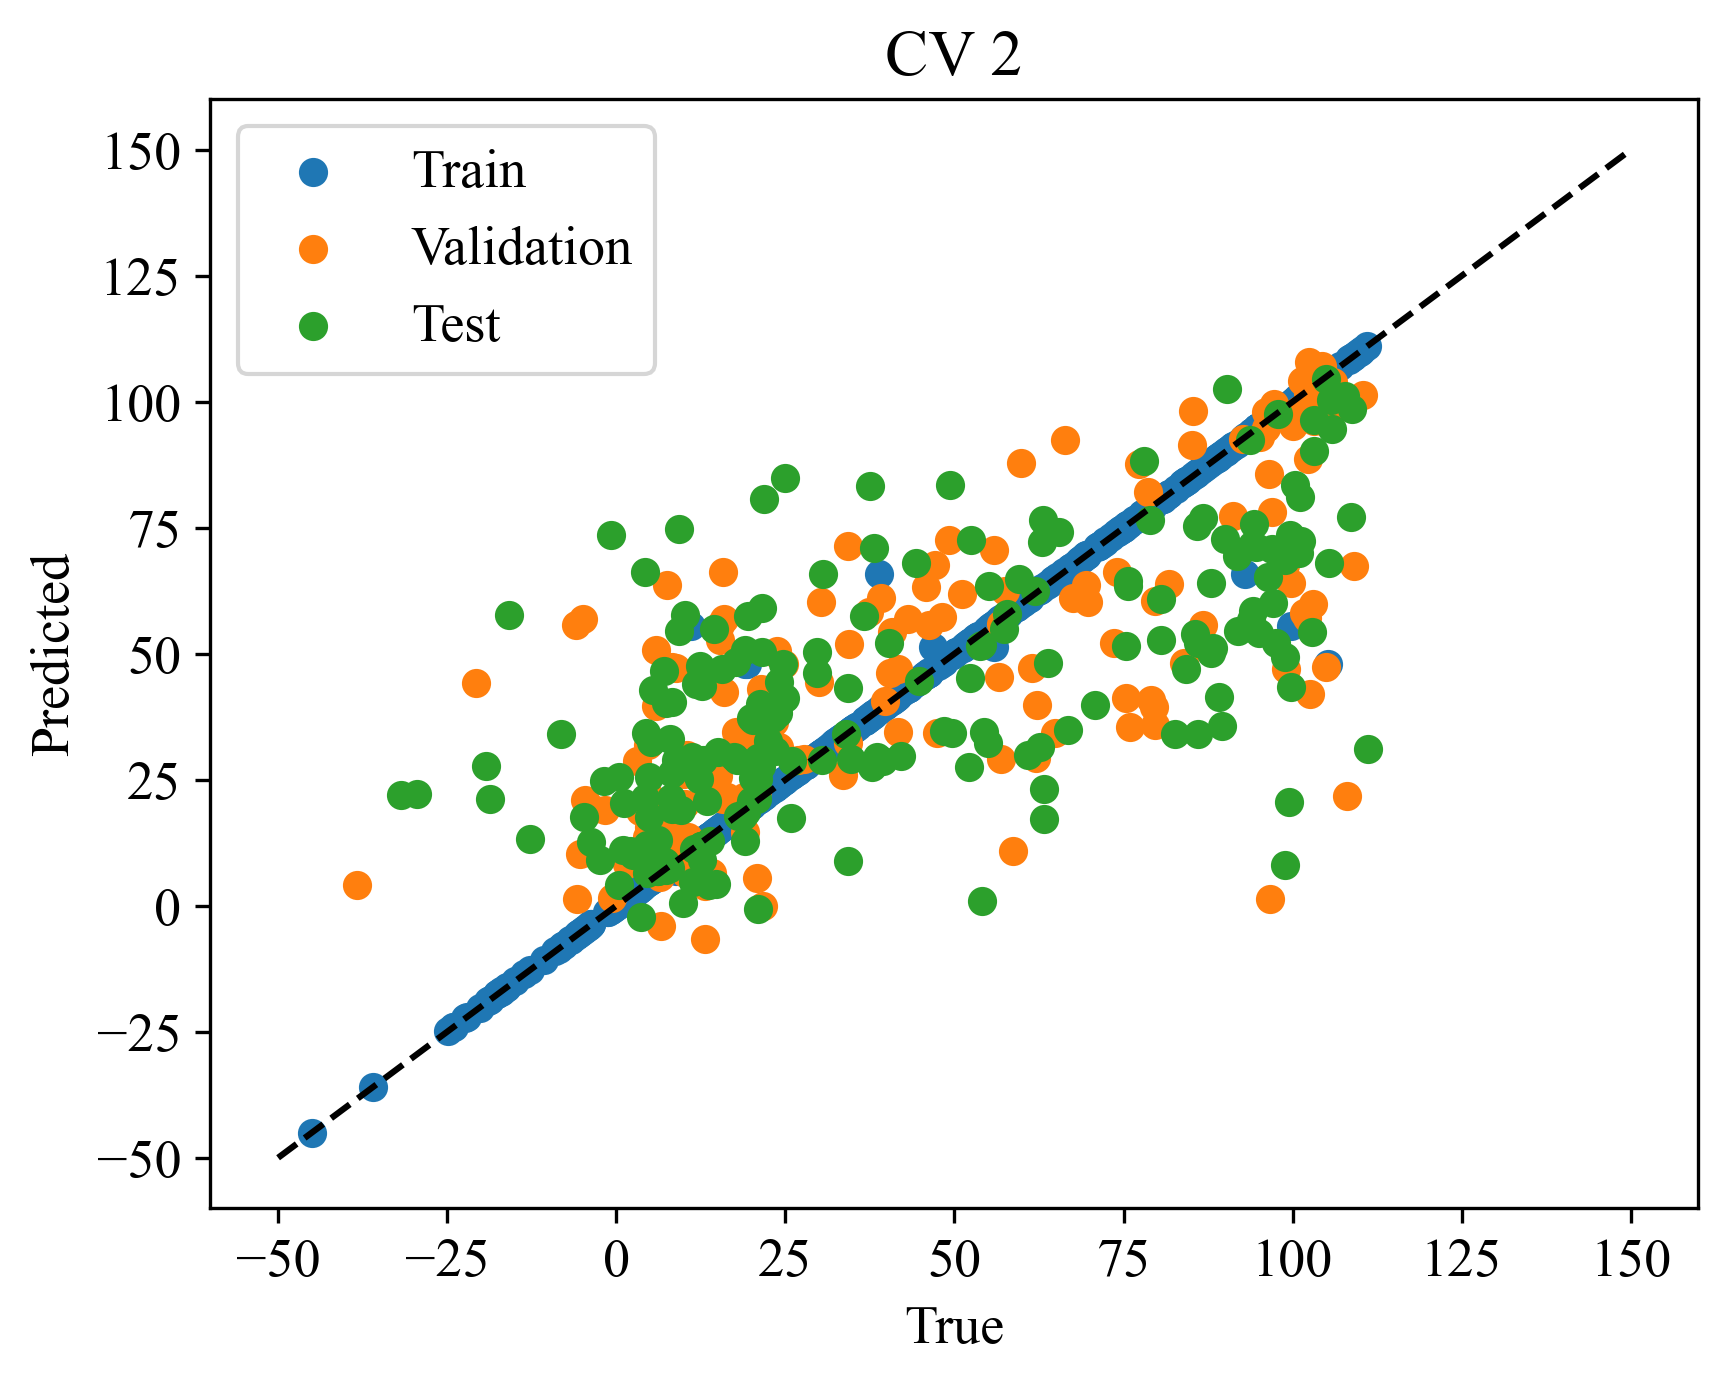

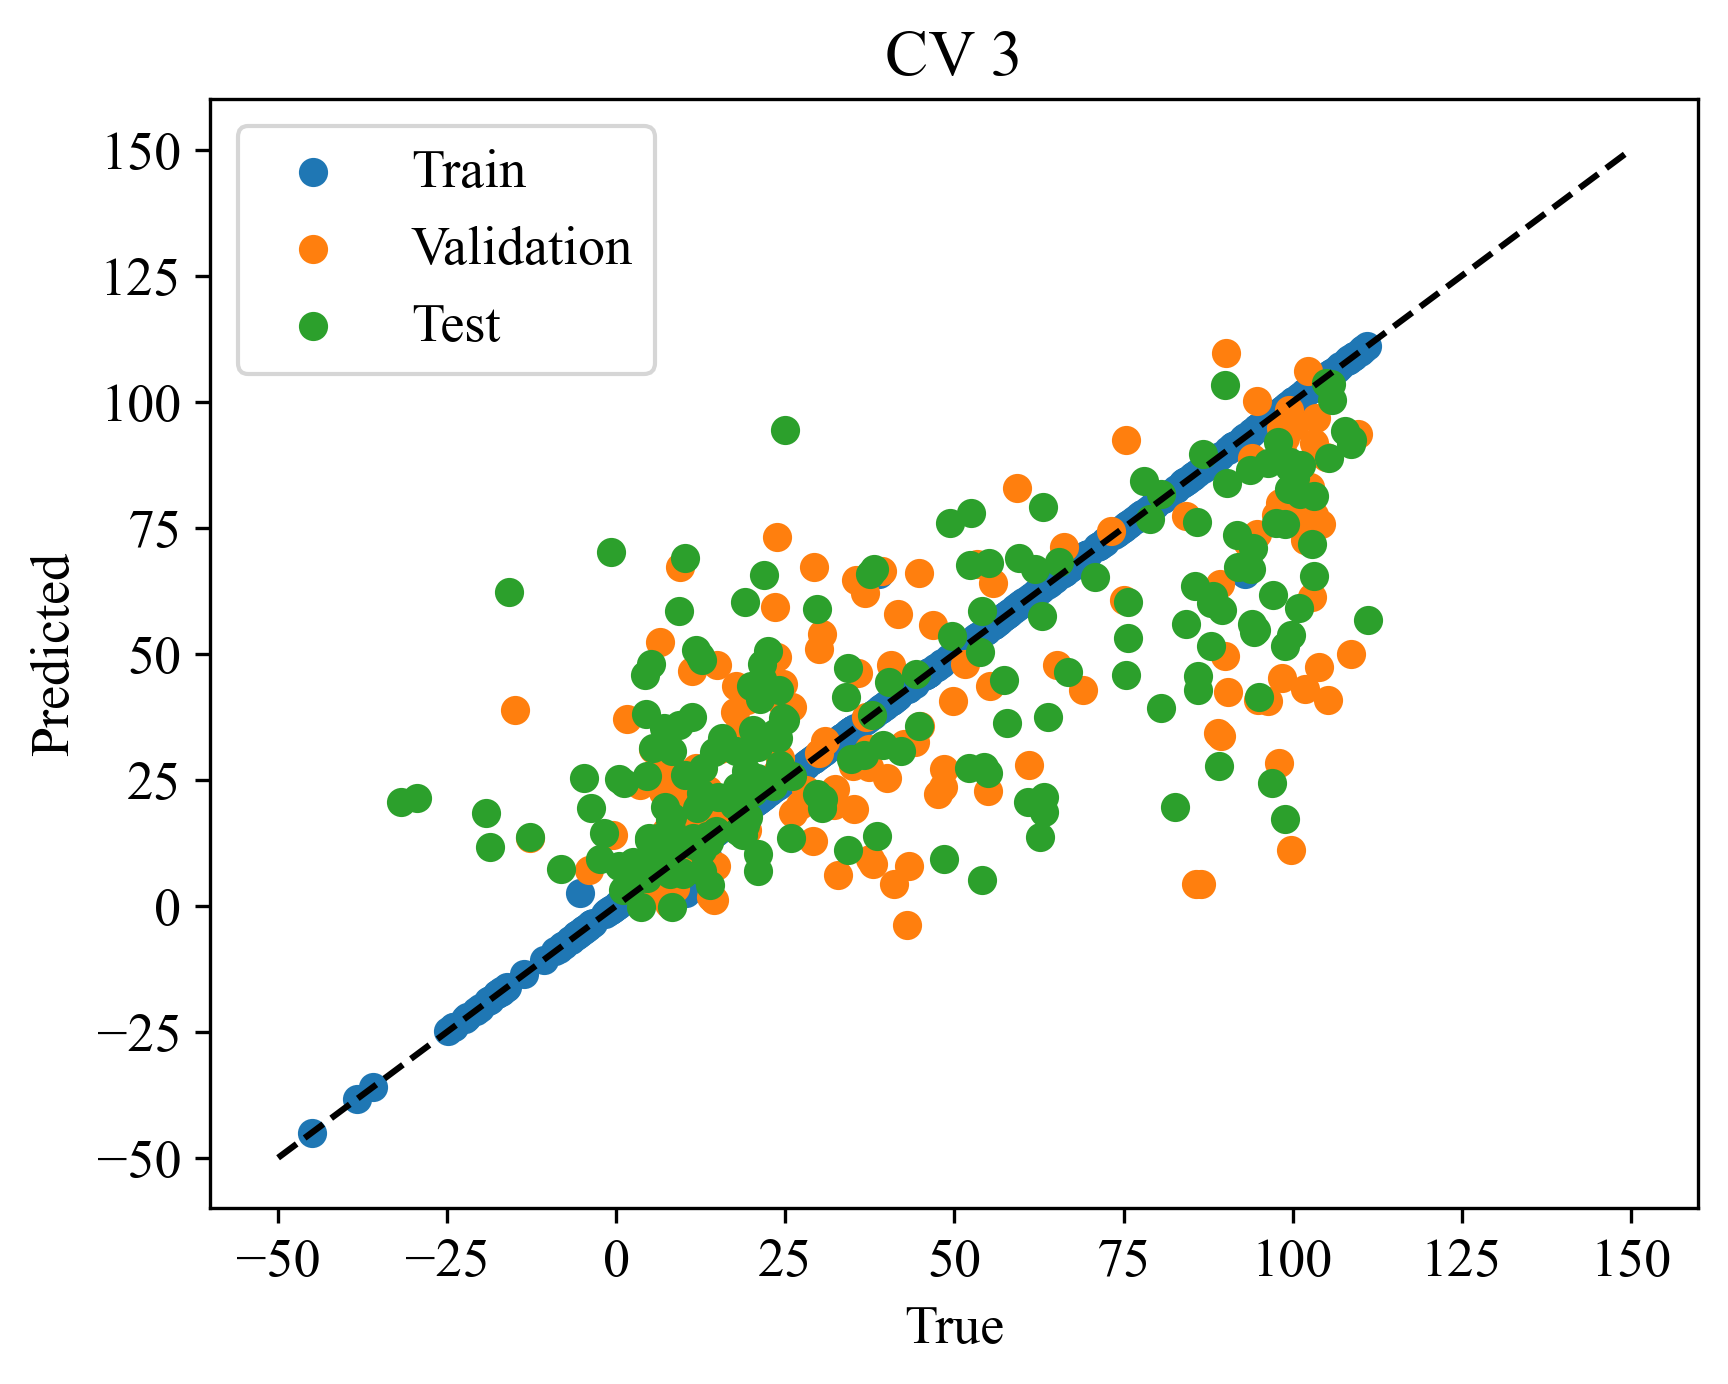

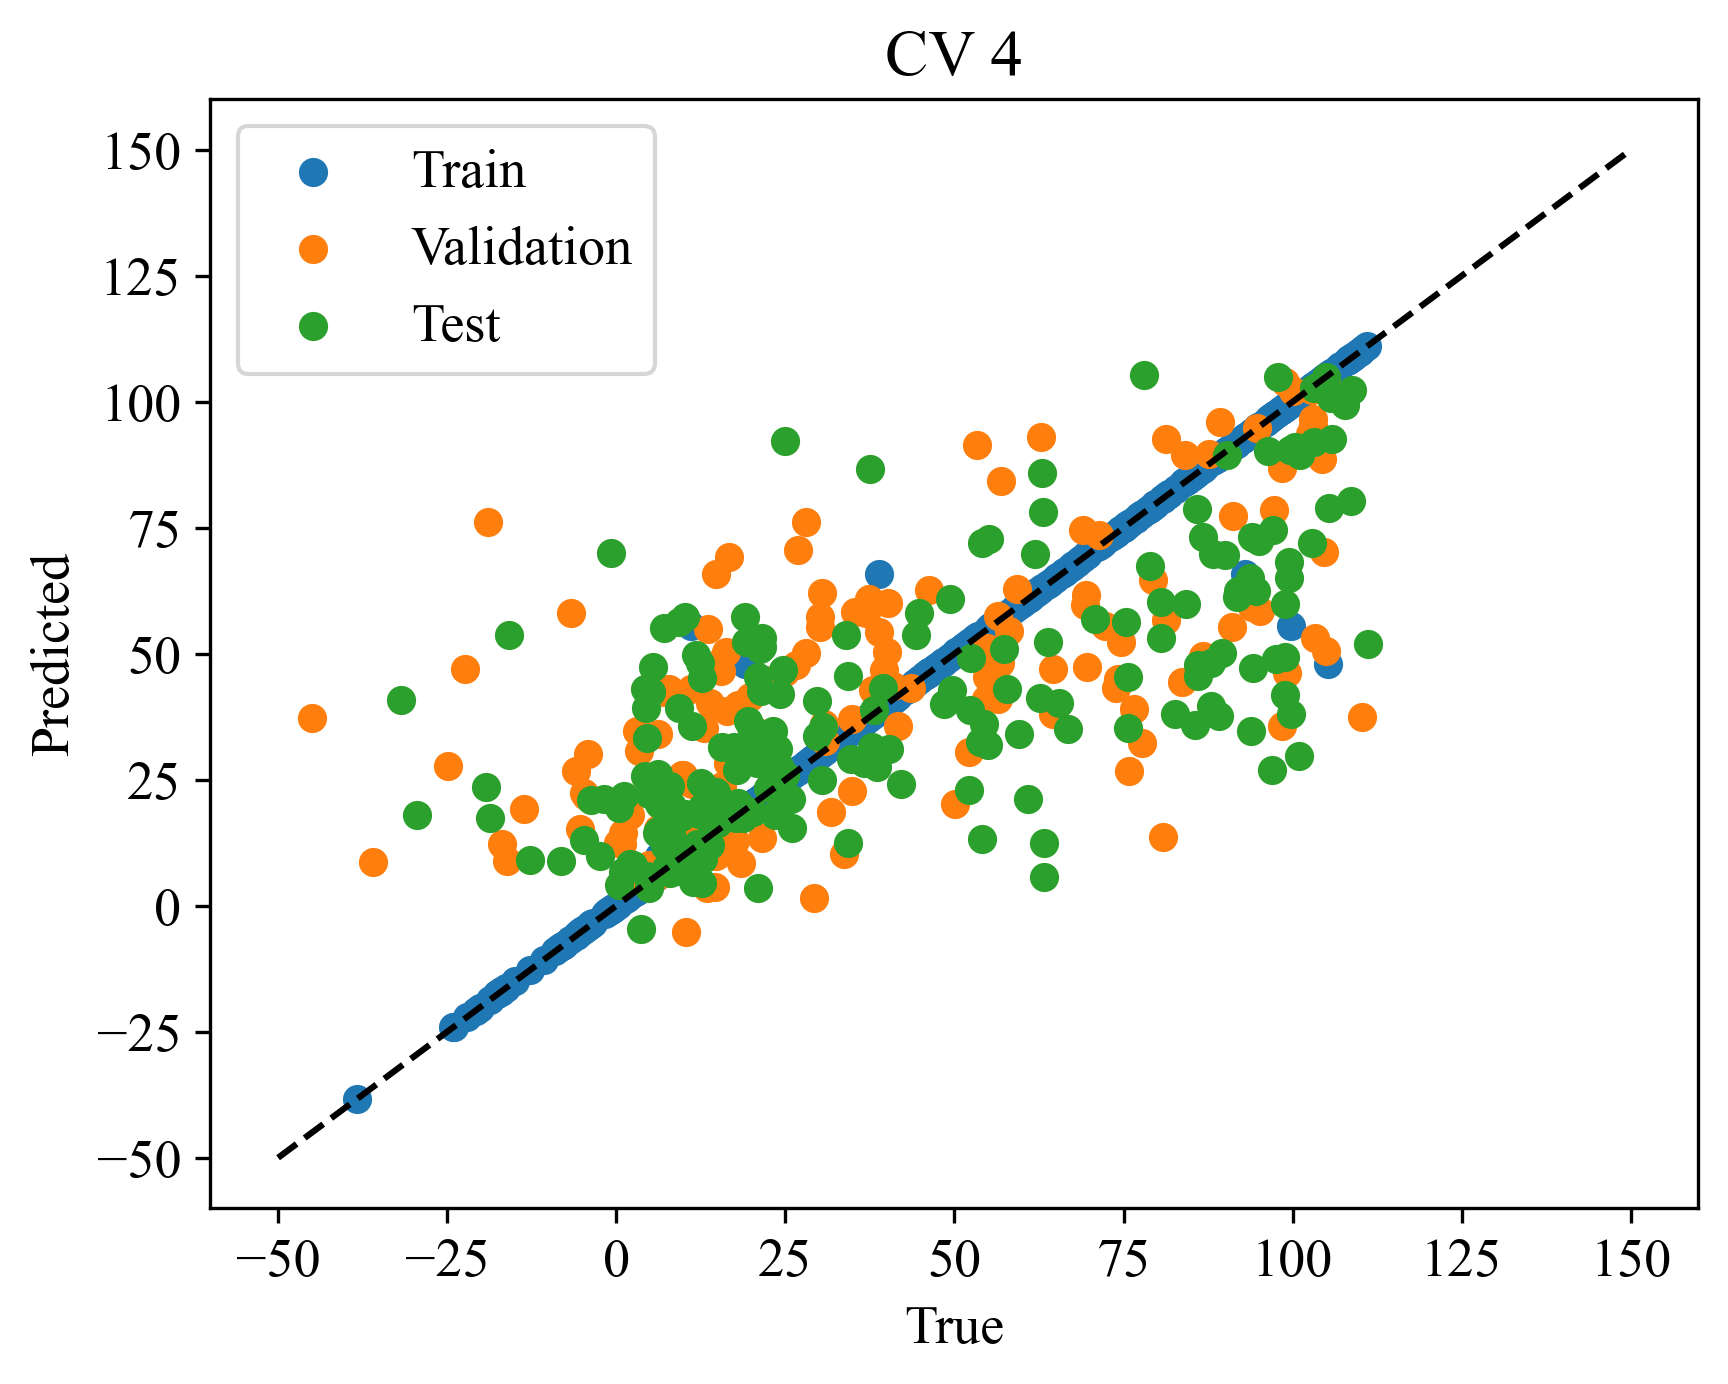

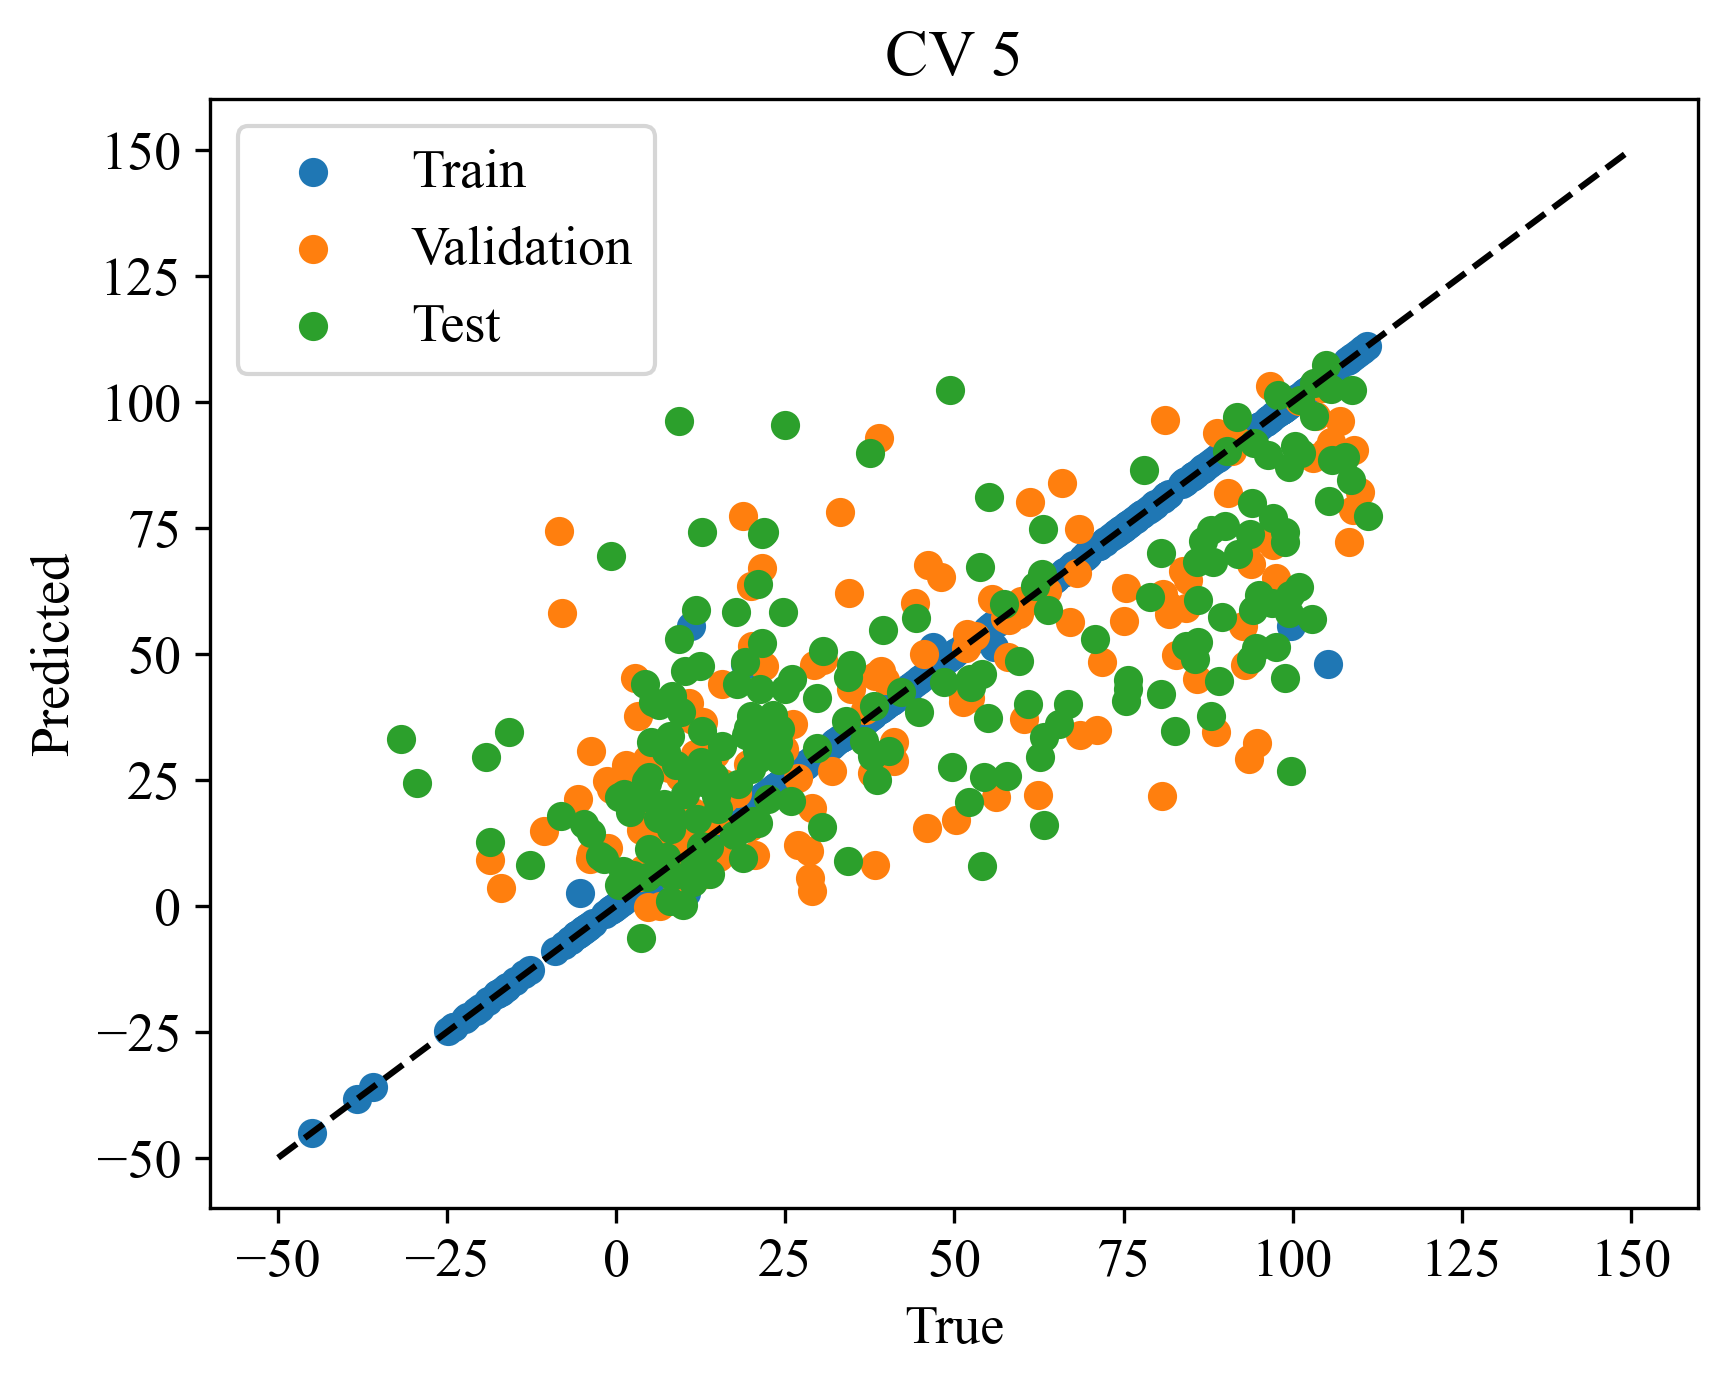

In [28]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=seed)
predictions = {'Train': [], 'Validation': [], 'Test': []}
rmse_results = {'Train': [], 'Validation': [], 'Test': []}
r2_results = {'Train': [], 'Validation': [], 'Test': []}
for i, (train_index, val_index) in enumerate(kfolds.split(X_train_scaled)):
    print(f"Fold {i+1}")
    # create the data
    X_train_fold, X_val_fold = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # instead the model
    model = xgb.XGBRegressor(learning_rate=best_params['learning_rate'],
                            max_depth=int(best_params['max_depth']),
                            min_child_weight=best_params['min_child_weight'],
                            n_estimators=int(best_params['n_estimators']),
                            reg_alpha=best_params['reg_alpha'],
                            reg_lambda=best_params['reg_lambda'],
                            seed=best_params['seed'])
    # train the model
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
    # predict the values
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    y_test_pred = model.predict(X_test_scaled)
    # calculate the errors
    rmse_train = percentage_rmse(y_train_fold, y_train_pred)
    rmse_val = percentage_rmse(y_val_fold, y_val_pred)
    rmse_test = percentage_rmse(y_test, y_test_pred)
    r2_train = model.score(X_train_fold, y_train_fold)
    r2_val = model.score(X_val_fold, y_val_fold)
    r2_test = model.score(X_test_scaled, y_test)
    # print the results
    print(f"Train RMSE: {rmse_train:.3f} %; Val RMSE: {rmse_val:.3f} %; Test RMSE: {rmse_test:.3f} %")
    print(f"Train R2: {r2_train:.3f}; Val R2: {r2_val:.3f}; Test R2: {r2_test:.3f}")
    # record the results
    predictions['Train'].append((y_train_pred, y_train_fold))
    rmse_results['Train'].append(rmse_train)
    r2_results['Train'].append(r2_train)
    rmse_results['Validation'].append(rmse_val)
    predictions['Validation'].append((y_val_pred, y_val_fold))
    r2_results['Validation'].append(r2_val)
    rmse_results['Test'].append(rmse_test)
    predictions['Test'].append((y_test_pred, y_test))
    r2_results['Test'].append(r2_test)
    # plot the results
    fig, ax = plt.subplots()
    ax.scatter(y_train_fold, y_train_pred, label='Train')
    ax.scatter(y_val_fold, y_val_pred, label='Validation')
    ax.scatter(y_test, y_test_pred, label='Test')
    ax.plot([-50, 150], [-50, 150], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(f'CV {i+1}')
    ax.legend()
    # dump the model
    with open(f"../saved_models/rdkit_descr_xgboost_CV_{i+1}.pkl", 'wb') as f:
        pickle.dump(model, f)
    

In [29]:
# print average results
print("Average results")
print("************ RMSE ************")
print(f"Train: {np.mean(rmse_results['Train']):.3f} %")
print(f"Validation: {np.mean(rmse_results['Validation']):.3f} %")
print(f"Test: {np.mean(rmse_results['Test']):.3f} %")
print("************ R2 ************")
print(f"Train: {np.mean(r2_results['Train']):.3f}")
print(f"Validation: {np.mean(r2_results['Validation']):.3f}")
print(f"Test: {np.mean(r2_results['Test']):.3f}")

Average results
************ RMSE ************
Train: 0.150 %
Validation: 5.696 %
Test: 7.977 %
************ R2 ************
Train: 0.991
Validation: 0.469
Test: 0.481


# Test on competition test data

In [41]:
actual_test_data = pd.read_csv('../data/tox24_test.csv')
print(f"Actual test data shape: {actual_test_data.shape}")
actual_test_data['can_SMILES'] = actual_test_data['SMILES'].apply(canonicalizer)
actual_test_data.head()

Actual test data shape: (500, 1)


,SMILES,can_SMILES
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,CC1=CC[C@H]2C[C@@H]1C2(C)C
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O
2,CC(C)=CCC\C(C)=C\CO,CC(C)=CCC/C(C)=C/CO
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC1=CC=C(C=C1)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O


In [42]:
# add each entry in descriptors to the dataframe
actual_test_data['mol'] = actual_test_data['can_SMILES'].apply(Chem.MolFromSmiles)
# add the descriptors to the dataframe
actual_test_data = pd.concat([actual_test_data, actual_test_data['mol'].apply(getMolDescriptors).apply(pd.Series)], axis=1)
actual_test_data.head()

,SMILES,can_SMILES,mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,CC1=CC[C@H]2C[C@@H]1C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x295c613c0>,2.434606,2.434606,0.637731,0.637731,0.448983,42.100000,136.238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x295a34f90>,10.530816,10.530816,0.545648,-0.986713,0.841130,12.214286,214.648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(C)=CCC\C(C)=C\CO,CC(C)=CCC/C(C)=C/CO,<rdkit.Chem.rdchem.Mol object at 0x296254f20>,8.553384,8.553384,0.167316,0.167316,0.617131,11.454545,154.253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC1=CC=C(C=C1)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,<rdkit.Chem.rdchem.Mol object at 0x2a3415dd0>,5.819561,5.819561,0.240302,0.240302,0.823292,25.181818,303.490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,<rdkit.Chem.rdchem.Mol object at 0x2a3415ac0>,12.204772,12.204772,0.075683,-0.946291,0.924288,14.555556,265.334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# get the X data
actual_X_test = actual_test_data.drop(columns=['SMILES', 'can_SMILES', 'mol'])
# scale the data
actual_X_test_scaled = scaler.transform(actual_X_test)
# to dataframe
actual_X_test_scaled = pd.DataFrame(actual_X_test_scaled, columns=actual_X_test.columns)

In [44]:
actual_X_test_scaled.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-2.656991,-2.656991,0.521871,0.894205,-0.510322,2.863503,-0.812024,-0.849891,-0.811234,-0.695141,...,-0.159891,-0.142947,-0.086441,-0.070491,0.0,-0.070491,-0.03518,-0.061009,-0.338433,-0.178169
1,0.222029,0.222029,0.361838,0.024470,1.693708,-0.255514,-0.282694,-0.260742,-0.284472,-0.318635,...,-0.159891,-0.142947,-0.086441,-0.070491,0.0,-0.070491,-0.03518,-0.061009,-0.338433,-0.178169
2,-0.481147,-0.481147,-0.295672,0.642343,0.434742,-0.334804,-0.690408,-0.736939,-0.689469,-0.544539,...,-0.159891,-0.142947,-0.086441,-0.070491,0.0,-0.070491,-0.03518,-0.061009,-0.338433,-0.178169
3,-1.453298,-1.453298,-0.168830,0.681419,1.593449,1.097840,0.317061,0.209914,0.318701,0.584982,...,-0.159891,-0.142947,-0.086441,-0.070491,0.0,-0.070491,-0.03518,-0.061009,-0.338433,-0.178169
4,0.817290,0.817290,-0.454923,0.046112,2.161089,-0.011168,0.059477,0.068631,0.060582,0.057872,...,-0.159891,-0.142947,-0.086441,-0.070491,0.0,-0.070491,-0.03518,-0.061009,-0.338433,-0.178169


In [45]:
# load the models
trained_models = []
for i in range(5):
    with open(f"../saved_models/rdkit_descr_xgboost_CV_{i+1}.pkl", 'rb') as f:
        trained_models.append(pickle.load(f))

trained_models

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09916398899082297,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=7.0519926461727875, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=660,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              en

In [46]:
# predict the values
y_preds = []
for model in trained_models:
    y_preds.append(model.predict(actual_X_test_scaled))

In [47]:
y_preds = np.array(y_preds)
y_preds.shape

(5, 500)

In [48]:
# find the average of the predictions
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_avg.shape

(500,)

In [51]:
# save the y_pred_avg to a csv file
actual_test_data['activity'] = y_pred_avg
# save the data "activity" to a csv file
actual_test_data['activity'].to_csv('../submissions/tox24-submission-predictions.csv', index=False, header=False)